# <center>1. Understanding the data</center>

### Firstly, we import all the necessary packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

import keras
from keras import optimizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor



Using TensorFlow backend.


### Loading the dataset

In [2]:
df = pd.read_csv('lego_Sets.csv')

### Brief preview of the dataset structure

In [3]:
display(df.head(5))

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_desc,prod_id,prod_long_desc,review_difficulty,set_name,star_rating,theme_name,val_star_rating,country
0,6-12,29.99,2.0,277.0,4.0,Catapult into action and take back the eggs fr...,75823.0,Use the staircase catapult to launch Red into ...,Average,Bird Island Egg Heist,4.5,Angry Birds™,4.0,US
1,6-12,19.99,2.0,168.0,4.0,Launch a flying attack and rescue the eggs fro...,75822.0,Pilot Pig has taken off from Bird Island with ...,Easy,Piggy Plane Attack,5.0,Angry Birds™,4.0,US
2,6-12,12.99,11.0,74.0,4.3,Chase the piggy with lightning-fast Chuck and ...,75821.0,Pitch speedy bird Chuck against the Piggy Car....,Easy,Piggy Car Escape,4.3,Angry Birds™,4.1,US
3,12+,99.99,23.0,1032.0,3.6,Explore the architecture of the United States ...,21030.0,Discover the architectural secrets of the icon...,Average,United States Capitol Building,4.6,Architecture,4.3,US
4,12+,79.99,14.0,744.0,3.2,Recreate the Solomon R. Guggenheim Museum® wit...,21035.0,Discover the architectural secrets of Frank Ll...,Challenging,Solomon R. Guggenheim Museum®,4.6,Architecture,4.1,US


Our goal is to predict value of the list_price variable - listing price of a certain toy in LEGO online store.

<b>country</b> variable is indicating which online store (from which country) is listing that item.

# <center>2. Preparing the dataset</center>

## 2.1 Removing useless data and fixing formats

Removing variables that would give no predictive power (information variables such as ID's or descriptions)

In [4]:
df = df.drop(['prod_desc', 
              'prod_id', 
              'prod_long_desc', 
              'set_name'],
             axis=1)

Changing categorical variables and list_price into right formats.

Also we are ordering review_difficulty since it is ordered scale of difficulty.

In [5]:
df.list_price = df.list_price.astype(float)
df['review_difficulty'] = df['review_difficulty'].astype("category")
df['review_difficulty'] = df['review_difficulty'].cat.reorder_categories(['Very Easy',
                                                               'Easy',
                                                               'Average',
                                                               'Challenging',
                                                               'Very Challenging'],
                                                                        ordered = True)
df['review_difficulty'] = df['review_difficulty'].cat.codes
df.theme_name = df.theme_name.astype(object)
df.ages = df.ages.astype(object)

## 2.2 Cleaning dataset from NA's

In [6]:
missing_data = pd.DataFrame({'Number of occurencies': df.isna().sum(),
                             'Percentage': 100*df.isna().sum()/len(df)
                            })
missing_data[missing_data['Number of occurencies'] > 0]

,Number of occurencies,Percentage
num_reviews,1620,13.212625
play_star_rating,1775,14.476796
star_rating,1620,13.212625
theme_name,3,0.024468
val_star_rating,1795,14.639915


Since the missings in star_rating (all 3 columns concerning them) are common for certain observations, maybe we can somehow reduce the number of them by filling missing values with computed value.

We mark the missings in review difficulty with a group code equal to -1.

We can see that star_rating has less NA's than play and val star_rating. We shall see if there is a correlation between those 3 variables. 

In [7]:
corr = df[['star_rating', 'play_star_rating', 'val_star_rating']].corr()
corr.style.background_gradient(cmap='coolwarm')

,star_rating,play_star_rating,val_star_rating
star_rating,1,0.608193,0.72789
play_star_rating,0.608193,1,0.480938
val_star_rating,0.72789,0.480938,1


Let us compute means of ratios between star_rating for the whole dataset and use that ratio to create values to impute instead of NA's.

Because of slightly high correlation we decide to omit star_rating and leave the two other ratings (and since they all have same number of NA's)

In [8]:
df['star/play'] = df['star_rating']/df['play_star_rating']
df['star/val'] = df['star_rating']/df['val_star_rating']

star_p_mean = df['star/play'].mean()
star_v_mean = df['star/val'].mean()

df.loc[(df['play_star_rating'].isnull()) & (df['star_rating'].notna()), "play_star_rating"] = df["star_rating"]*star_p_mean
df.loc[(df['val_star_rating'].isnull()) & (df['star_rating'].notna()), "val_star_rating"] = df["star_rating"]*star_v_mean

df.drop(['star/play', 'star/val', 'star_rating'], axis=1, inplace=True)

That way we manage to narrow our total rows with NA's to 1620. Unfortunately there is no way to safely replace values for these observations (which all have at least 3 NA's) so we will omit them in further analysis.

In [9]:
df.loc[df.isnull().sum(1)>=3].index

df = df.dropna()

## 2.3 Checking for correlations and encoding categorical variables - using One Hot Encoding

Creating correlation matrix:

In [10]:
corr = df.drop(['list_price'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,num_reviews,piece_count,play_star_rating,review_difficulty,val_star_rating
num_reviews,1,0.546616,-0.0451145,0.328073,0.0148351
piece_count,0.546616,1,0.0147979,0.509112,0.0636759
play_star_rating,-0.0451145,0.0147979,1,0.018671,0.499167
review_difficulty,0.328073,0.509112,0.018671,1,-0.00300082
val_star_rating,0.0148351,0.0636759,0.499167,-0.00300082,1


There are no visible very high correlations (some ~0.5, but we decide to leave them in further analysis, because these are not worrying values).

In [11]:
cat_vars = []
cont_vars = []
for variable in df.columns:
    if df[variable].dtype==object:
        cat_vars.append(variable)
    else:
        cont_vars.append(variable)
        
num_of_cats = {}
for category in cat_cols:
    num_of_cats[category] = len(list(df[category].unique()))
    
print(num_of_cats)

NameError: name 'cat_cols' is not defined

We can see that all the variables have a lot of levels, let's see how different are the numbers of observations within each level on barplots below.

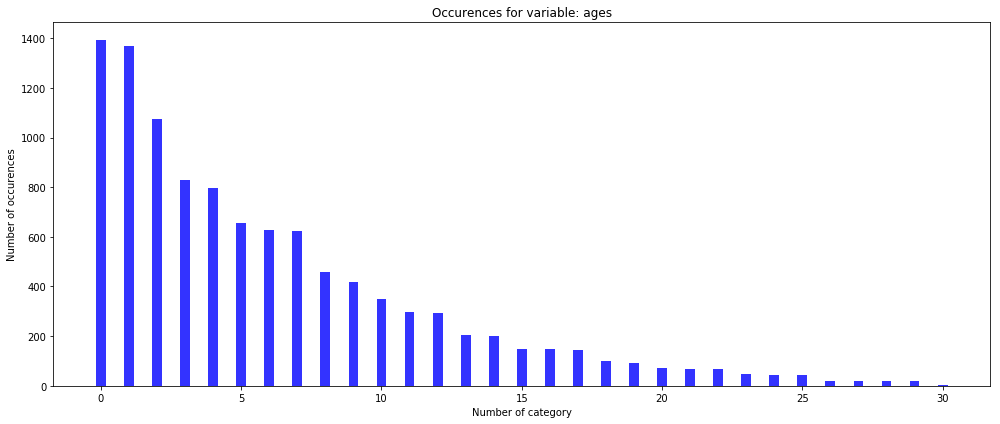

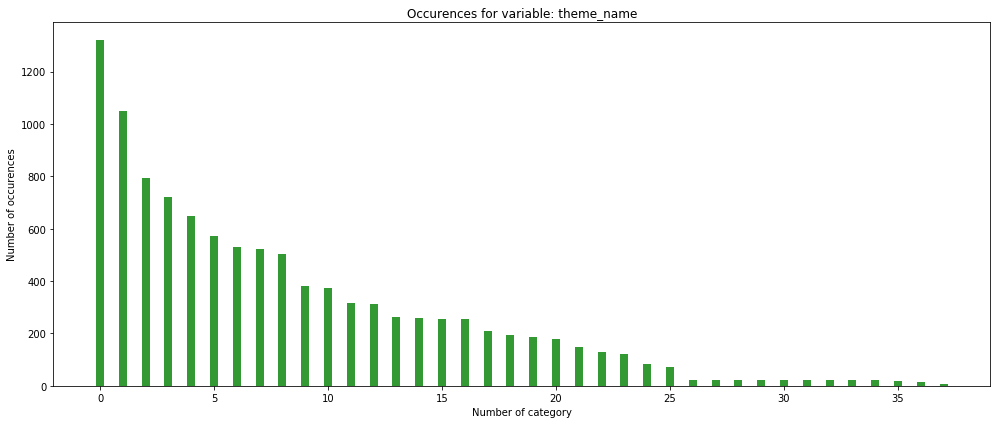

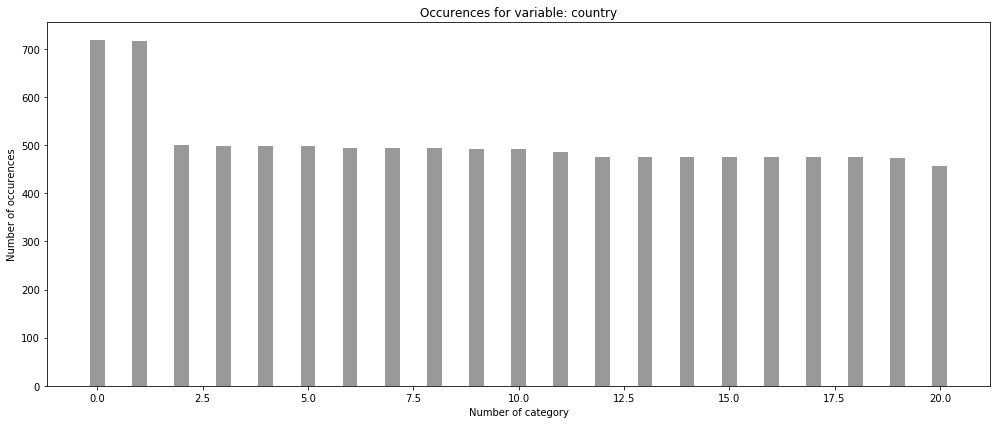

In [12]:
bar_width = 0.35
opacity = 0.8
colors = ["b","g","grey"]


for idx, var in enumerate(cat_vars):
    plt.figure(figsize=(14,6))
    boo = list(dict(df[var].value_counts()).values())
    leng = np.arange(len(list(dict(df[var].value_counts()).values())))
    rects = plt.bar(leng, boo, bar_width,
    alpha=opacity,
    color=colors[idx])
    plt.ylabel('Number of occurences')
    plt.xlabel('Number of category')
    plt.title('Occurences for variable: {}'.format(var))
    plt.tight_layout()
    plt.show()

Since there are no categories that would be very differently populated than the rest (they gradually descent) we decided to keep all the variables for one hot encoding.

Next we are creating dummy variables through one hot encoding for each category in categorical variables (omitting review_difficulty in which we introduced ordered categories).

In [19]:
df2 = pd.get_dummies(df, drop_first=True)

## 2.4 Splitting dataset into training and testing dataset

In [20]:
X, Y = df2.drop(['list_price'], axis=1), df2['list_price']

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, 
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=361)

In [21]:
df2.shape

(10638, 93)

We are left with 10638 observations and 92 variables which we have split into 70/30 train/test datasets. 

That way we are ready to begin estimating predictive models using 3 different methods.

# <center>3.1 Estimating Linear Regression (OLS) model</center>

In [23]:
X_train_lin = sm.add_constant(X_train)
X_test_lin = sm.add_constant(X_test)# adding a constant
 
model = sm.OLS(Y_train, X_train_lin).fit()
Y_pred = model.predict(X_test_lin) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     533.6
Date:                Sun, 09 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:26:31   Log-Likelihood:                -37322.
No. Observations:                7446   AIC:                         7.482e+04
Df Residuals:                    7357   BIC:                         7.544e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------